In [67]:
import torch
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.memory_summary(device=None, abbreviated=False)
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch


In [68]:
test_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/test_df.csv"
val_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/valid_df.csv"
train_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/train_df.csv"

import pandas as pd
import numpy as np

train_data_source = pd.read_csv(train_path)
train_data = train_data_source[['video','text', 'target']]

val_data_source = pd.read_csv(val_path)
val_data = val_data_source[['video','text', 'target']]

test_data_source = pd.read_csv(test_path)
test_data = test_data_source[['video','text', 'target']]


In [69]:

train_texts = train_data['text'].tolist()
train_labels =  train_data['target'].tolist()
train_video_ids =  train_data['video'].tolist()

test_texts = test_data['text'].tolist()
test_labels =  test_data['target'].tolist()
test_video_ids =  test_data['video'].tolist()

val_texts = val_data['text'].tolist()
val_labels =  val_data['target'].tolist()
val_video_ids =  val_data['video'].tolist()



In [70]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)
val_encodings = tokenize(val_texts)


In [71]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels, video_ids):
        self.encodings = encodings
        self.labels = labels
        self.video_ids = video_ids

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['video_ids'] = self.video_ids[idx]
        return item

train_dataset = TextDataset(train_encodings, train_labels, train_video_ids)
test_dataset = TextDataset(test_encodings, test_labels, test_video_ids)
val_dataset = TextDataset(val_encodings, val_labels, val_video_ids)

In [72]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [73]:
model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Freeze embeddings and encoder layers 0–20 (i.e., first 21 layers)
for name, param in model.named_parameters():
    if name.startswith("roberta.embeddings"):
        param.requires_grad = False
    elif "roberta.encoder.layer" in name:
        layer_num = int(name.split("layer.")[1].split(".")[0])
        if layer_num < 21:
            param.requires_grad = False

# Optional: confirm what's still trainable
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters:
roberta.encoder.layer.21.attention.self.query.weight
roberta.encoder.layer.21.attention.self.query.bias
roberta.encoder.layer.21.attention.self.key.weight
roberta.encoder.layer.21.attention.self.key.bias
roberta.encoder.layer.21.attention.self.value.weight
roberta.encoder.layer.21.attention.self.value.bias
roberta.encoder.layer.21.attention.output.dense.weight
roberta.encoder.layer.21.attention.output.dense.bias
roberta.encoder.layer.21.attention.output.LayerNorm.weight
roberta.encoder.layer.21.attention.output.LayerNorm.bias
roberta.encoder.layer.21.intermediate.dense.weight
roberta.encoder.layer.21.intermediate.dense.bias
roberta.encoder.layer.21.output.dense.weight
roberta.encoder.layer.21.output.dense.bias
roberta.encoder.layer.21.output.LayerNorm.weight
roberta.encoder.layer.21.output.LayerNorm.bias
roberta.encoder.layer.22.attention.self.query.weight
roberta.encoder.layer.22.attention.self.query.bias
roberta.encoder.layer.22.attention.self.key.weight
roberta

In [74]:
epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in loop:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        
        inputs = {k: v for k, v in batch.items() if k != "video_ids"}

        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        inputs = {k: v for k, v in batch.items() if k != "video_ids"}
        outputs = model(**inputs)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Epoch 1 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


[Epoch 1] Train Loss: 0.7031, Train Acc: 0.5386 | Val Loss: 0.6909, Val Acc: 0.5487


Epoch 2 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 2] Train Loss: 0.6639, Train Acc: 0.5901 | Val Loss: 0.6547, Val Acc: 0.6462


Epoch 3 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 3] Train Loss: 0.5735, Train Acc: 0.7118 | Val Loss: 0.6136, Val Acc: 0.6872


Epoch 4 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 4] Train Loss: 0.5382, Train Acc: 0.7633 | Val Loss: 0.6043, Val Acc: 0.6872


Epoch 5 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 5] Train Loss: 0.4413, Train Acc: 0.7959 | Val Loss: 0.6538, Val Acc: 0.6462


Epoch 6 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 6] Train Loss: 0.3901, Train Acc: 0.8370 | Val Loss: 0.6613, Val Acc: 0.6667


Epoch 7 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 7] Train Loss: 0.2923, Train Acc: 0.8679 | Val Loss: 0.6719, Val Acc: 0.7282


Epoch 8 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 8] Train Loss: 0.2163, Train Acc: 0.9091 | Val Loss: 0.7386, Val Acc: 0.6974


Epoch 9 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 9] Train Loss: 0.1142, Train Acc: 0.9571 | Val Loss: 0.9308, Val Acc: 0.7231


Epoch 10 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


[Epoch 10] Train Loss: 0.0910, Train Acc: 0.9640 | Val Loss: 0.9698, Val Acc: 0.7231


Final Test Evaluation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

Final Test Accuracy: 0.7590


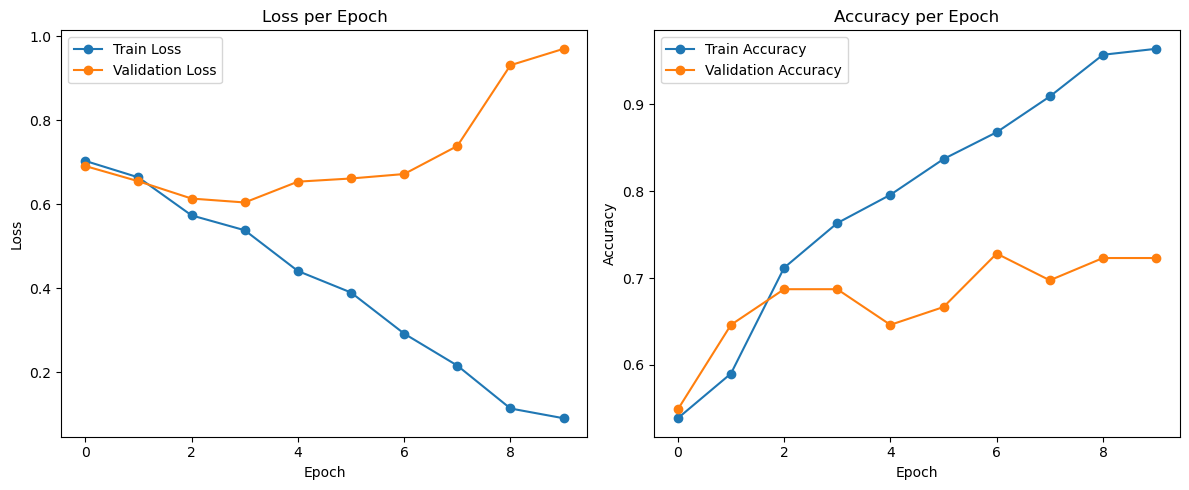

In [75]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [76]:
import torch
import torch.nn.functional as F

def generate_predictions(model, dataloader):
    model.eval()
    all_video_ids = []
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k != "video_ids"}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)  # Get probabilities from logits
            preds = torch.argmax(probs, dim=1)  # Get predicted class
            
            all_video_ids.extend(batch['video_ids'])
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_video_ids), np.array(all_probs), np.array(all_preds), np.array(all_labels)


In [77]:
video_ids, probs, preds, labels = generate_predictions(model, train_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "video": video_ids,
    "true_label": labels,
    "pred_label": preds,
    "prob_class_0": probs[:, 0],
    "prob_class_1": probs[:, 1]
})

df.to_csv("text_train_predictions.csv", index=False)
print("Saved predictions to text_train_predictions.csv")



Generating Predictions: 100%|██████████| 37/37 [00:17<00:00,  2.16it/s]

Test Accuracy: 0.9949
Test Macro F1 Score: 0.9948
Saved predictions to text_train_predictions.csv


In [78]:
video_ids, probs, preds, labels = generate_predictions(model, test_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "video": video_ids,
    "true_label": labels,
    "pred_label": preds,
    "prob_class_0": probs[:, 0],
    "prob_class_1": probs[:, 1]
})

df.to_csv("text_test_predictions.csv", index=False)
print("Saved predictions to text_test_predictions.csv")

Generating Predictions: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

Test Accuracy: 0.7590
Test Macro F1 Score: 0.7569
Saved predictions to text_test_predictions.csv


In [79]:
video_ids, probs, preds, labels = generate_predictions(model, val_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "video": video_ids,
    "true_label": labels,
    "pred_label": preds,
    "prob_class_0": probs[:, 0],
    "prob_class_1": probs[:, 1]
})

df.to_csv("text_val_predictions.csv", index=True)
print("Saved predictions to text_val_predictions.csv")

Generating Predictions: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

Test Accuracy: 0.7231
Test Macro F1 Score: 0.7060
Saved predictions to text_val_predictions.csv


In [80]:
# Save just the model's state dict (weights)
torch.save(model.state_dict(), "model_weights.pt")


In [8]:
# Recreate the model architecture first
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load("model_weights.pt", map_location=device))

# Move to device
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3761075/2181143520.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru